In [38]:
# Imports
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from pyeeg import *
import matplotlib.pyplot as plt
from xgboost import XGBRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import KFold
from sklearn.metrics import r2_score
import tsfresh
import pandas as pd
from utils.split import split_features_and_labels
import pickle

In [18]:
# Things associated with the GAMEEMO dataset
electrodes ='AF3 AF4 F3 F4 F7 F8 FC5 FC6 O1 O2 P7 P8 T7 T8'.split(' ')
electrodes_to_use = ['O1', 'O2', 'F7', 'F8']
sample_rate = 128
bands = [0.5, 4, 7, 12, 30, 50]

In [19]:
electrodes_idx = np.asarray([electrodes.index(e) for e in electrodes_to_use])

In [5]:
# In summary, the resulting features are an array containing raw EEG data split into 5-second intervals. 
# (dimensionality of n subjects*n trials*slice_amt x n_electrodes x 128*5), which I'll call batch size.
# and the labels are an array containing valence and arousal for each 5-second interval.
# (dimensionality of n subjects*n trials*slice_amt x 2)

eeg_splitted_features = np.load('gameemo_features.npy')
eeg_splitted_labels = np.load('gameemo_labels.npy')
eeg_splitted_features = eeg_splitted_features[:, electrodes_idx, :]
print(eeg_splitted_features.shape)

(112, 4, 38252)


In [6]:
eeg_splitted_features, eeg_splitted_labels = split_features_and_labels(eeg_splitted_features, eeg_splitted_labels, sample_rate, 5)

drop_locs = np.any(eeg_splitted_labels <0, axis=-1)
eeg_splitted_features = eeg_splitted_features[np.logical_not(drop_locs)]
eeg_splitted_labels = eeg_splitted_labels[np.logical_not(drop_locs)]

In [7]:
# Labels are originally scaled between 1 and 5. We transform them between 0 and 1.
scaled_labels = eeg_splitted_labels
#scaled_labels = MinMaxScaler().fit_transform(eeg_splitted_labels)
valence_labels = scaled_labels[:, 0]
arousal_labels = scaled_labels[:, 1]

In [8]:

# Extract power bands; we first flatten the first two dimensions to obtain a 2D array of voltage timeseries, we calculate band power for each electrode separately, then get the electrode dimension back. This gives us a dimensionality of (batch size x n electrodes x n bands)
reshaped_features = np.reshape(eeg_splitted_features, [eeg_splitted_features.shape[0]*eeg_splitted_features.shape[1], eeg_splitted_features.shape[2]])
extracted_powers = np.asarray([bin_power(X=feature, Band=bands,  Fs=sample_rate) for feature in reshaped_features])[:, 0, :]
extracted_powers = np.reshape(extracted_powers, [eeg_splitted_features.shape[0], eeg_splitted_features.shape[1], extracted_powers.shape[1]])
print(extracted_powers.shape)


(6549, 4, 5)


In [24]:

feature_names = np.asarray([[str(bands[x]) + '-' +str(bands[x+1]) + '|' + e for x in range(len(bands)-1)] for e in np.asarray(electrodes, dtype='object')[electrodes_idx]], dtype='object')
feature_names = np.ravel(feature_names)
print(feature_names)

['0.5-4|O1' '4-7|O1' '7-12|O1' '12-30|O1' '30-50|O1' '0.5-4|O2' '4-7|O2'
 '7-12|O2' '12-30|O2' '30-50|O2' '0.5-4|F7' '4-7|F7' '7-12|F7' '12-30|F7'
 '30-50|F7' '0.5-4|F8' '4-7|F8' '7-12|F8' '12-30|F8' '30-50|F8']


In [25]:
# Then we flatten the last two dimensions, leaving some number of bands per electrode as the final feature for each data point.
final_features = np.reshape(extracted_powers, [extracted_powers.shape[0], extracted_powers.shape[1]*extracted_powers.shape[2]])

In [46]:
# We do k-fold cross validation, meaning that we hold out 10% of the data, train on the other 90%, and evaluate the model performance on the original 10%.
# We repeat this process k times. 
# As we can see, there is some overfitting as the train R^2 is much higher than the test R^2.
regressors = []
kf = KFold(n_splits=10, shuffle=True)
i = 0
importances =[]
all_predictions_arousal = np.zeros((final_features.shape[0], ))
for train_index, test_index in kf.split(final_features):
    x_train = final_features[train_index]
    y_train = arousal_labels[train_index]
    x_test = final_features[test_index]
    y_test = arousal_labels[test_index]

    xgb =  XGBRegressor()
    xgb.fit(x_train, y_train)
    regressors.append(xgb)

    print('Fold number ' + str(i))
    y_pred = xgb.predict(x_train)
  #  print('Train R^2: ' + str(r2_score(y_train, y_pred)))
    y_pred = xgb.predict(x_test)
  #  print('Test R^2: ' + str(r2_score(y_test, y_pred)))
    importances.append(xgb.feature_importances_)
    all_predictions_arousal[test_index] = y_pred
    i += 1
print(r2_score(arousal_labels,all_predictions_arousal))

Fold number 0
Fold number 1
Fold number 2
Fold number 3
Fold number 4
Fold number 5
Fold number 6
Fold number 7
Fold number 8
Fold number 9
0.4332347130372213


In [50]:
class AverageXGBRegressor(object):
    def __init__(self, regressors, electrodes_used):
        self.regressors = regressors
        self.electrodes_used = electrodes_used
    def predict(self, x):
        predictions = np.mean([xgb.predict(x) for xgb in self.regressors], axis=0)
        return predictions

average_predictor = AverageXGBRegressor(regressors, electrodes_to_use)
print('This score should be high because of overfitting, but not low')
print(r2_score(arousal_labels, average_predictor.predict(final_features)))
pickle.dump(average_predictor,open('average_regressor.pkl', 'wb'))


This score should be high because of overfitting, but not low
0.921448654121939


In [29]:
df = pd.DataFrame()
df['feature_name'] = feature_names
df['mean_importances'] = np.sum(np.asarray(importances), axis=0)
df['electrode'] = [x.split('|')[1] for x in df['feature_name']]
df.sort_values('mean_importances', ascending = False)


,feature_name,mean_importances,electrode
9,30-50|O2,1.012154,O2
18,12-30|F8,1.001162,F8
14,30-50|F7,0.586898,F7
11,4-7|F7,0.575869,F7
3,12-30|O1,0.564417,O1
5,0.5-4|O2,0.530391,O2
8,12-30|O2,0.515284,O2
12,7-12|F7,0.502668,F7
4,30-50|O1,0.497783,O1
17,7-12|F8,0.493667,F8


Text(0, 0.5, 'Predicted arousal')

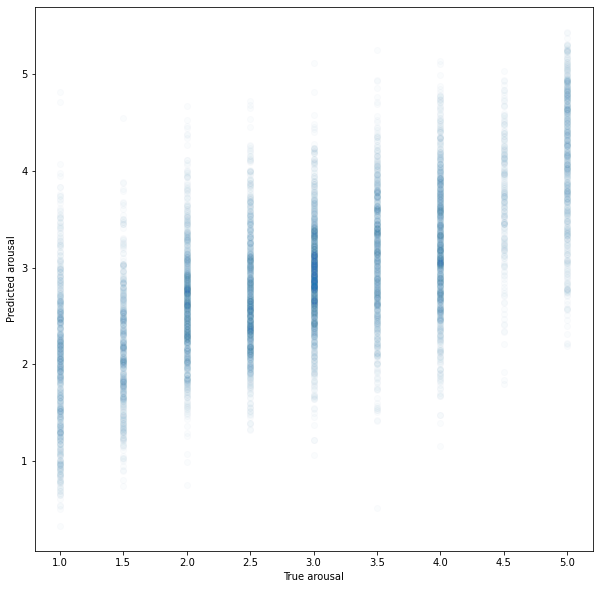

In [30]:
plt.figure(figsize=(10, 10))

plt.scatter(arousal_labels, np.expand_dims(all_predictions_arousal,axis=-1), alpha=0.02)
plt.xlabel('True arousal')
plt.ylabel('Predicted arousal')

Text(0, 0.5, 'Arousal')

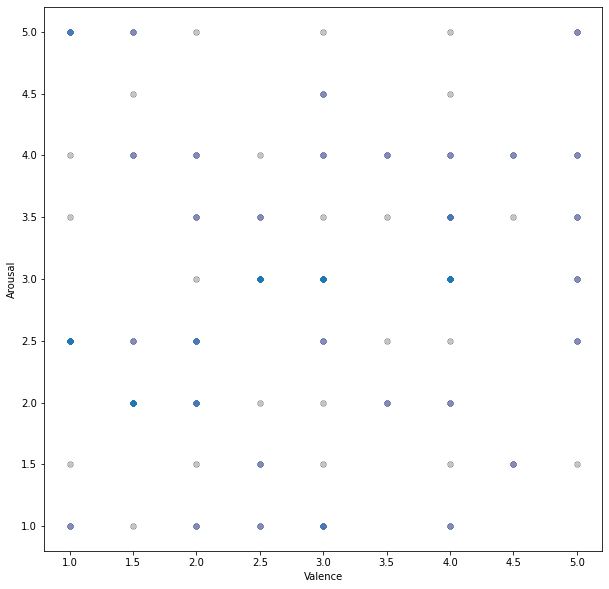

In [31]:
# A plot of the label space, the valence and arousal.
# The darker the blue, the more total labels are stacked on top of that point.

plt.figure(figsize=(10, 10))
plt.scatter(scaled_labels[:, 0], scaled_labels[:, 1], alpha=0.005)
plt.xlabel('Valence')
plt.ylabel('Arousal')